## 주택 가격 예측: 회귀 문제
### 보스턴 주택 가격 데이터셋

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape, test_data.shape

((404, 13), (102, 13))

In [2]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### 데이터 준비
* 상이한 스케일을 가진 값을 신경망에 주입하면 문제가 될 수 있다.
* 네트워크가 이련 다양한 데이터에 자동으로 맞추려고 할 수 있지만 이는 확실히 학습을 더 어렵게 만든다.
* 이런 데이터를 다룰 때 대표적인 방법은 특성별로 정규화를 하는 것이다.
* 입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 퓨준 편차로 나눈다. - 표준화(Standardization)
* 특성의 중앙이 0 근처에 맞추어지고 표준 편차가 1이 된다.

In [3]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### 모델 구성
* 일반적으로 훈련 데이터의 개수가 적을수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법이다.

In [4]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### K-겹 검증을 사용한 순련 검증
* 데이터를 K개의 분할(즉 폴드(fold))로 나누고(일반적으로 K=4 또는 5), K개의 모델을 각각 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법.
* 모델의 검증 점수는 K개의 검증 점수 평균.

In [5]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )

    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

fold # 0
fold # 1
fold # 2
fold # 3


In [6]:
all_scores

[2.052562713623047, 2.331930160522461, 2.710352897644043, 2.7400383949279785]

In [7]:
np.mean(all_scores)

2.4587210416793823

In [9]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

fold # 0
fold # 1
fold # 2
fold # 3


In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

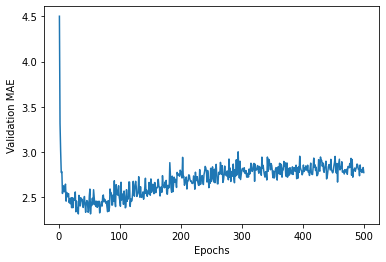

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

* 이 그래프는 범의가 크고 변동이 심하기 때문에 보기가 좀 어렵다.
    * 곡선의 다른 부분과 스케일이 많이 다른 쳣 10개의 데이터 포인트를 제외시킨다.
    * 부드러운 각선을 얻기 위해 각 포인트를 이전 포인트의 **지수 이동 평균**(exponential moving average)으로 대체한다.
    * 지수 이동 평균은 시계열 데이터를 부드럽게 만드는 기법 중 하나.
    * 이전에 계산된 이동 평균에 `factor`를 곱하고 현채 포인트에 `(1 - factor)`를 곱해 합산한 것.

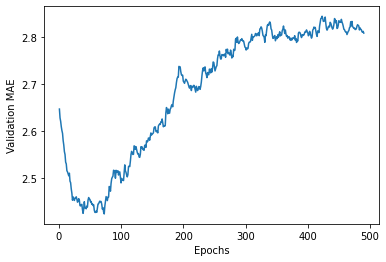

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)

    return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

* 모델의 여러 매개변수에 대한 튜닝이 끝나면(에포트 수뿐만 아니라 은닉 층의 크기도 조절할 수 있다.) 모든 훈련 데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련시킨다.
* 그다음 테스트 데이터로 성능을 확인한다.

In [14]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 1ms/step - loss: 18.9044 - mae: 2.7228


2.7227773666381836

### 정리
* 회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용한다. 평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수이다.
* 비슷하게 회귀에서 사용되는 평가 지표는 분류와 다르다. 일반적인 회귀 지표는 평균 절대 오차(MAE)이다.
* 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정해야 한다.
* 가용한 데이터가 적다면 K-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 평가 방법이다.
* 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉 층의 수를 줄인 모델이 좋다.

## 요약
* 보통 원본 데이터를 신경망에 주입하기 전에 전처리해야 한다.
* 데이터에 범위가 다른 특성이 있다면 전처리 단계에서 각 특성을 독립적으로 스케일 조정해야 한다.
* 훈련이 진행됨에 따라 신경망의 과대적합이 시작되고 새로운 데이터에 대해 나쁜 결과를 얻게 된다.
* 훈련 데이터가 많지 않으면 과대적합을 피하기 위해 1개 또는 2개의 은닉 층을 가진 신경망을 사용한다.
* 데이터가 많은 범주로 나뉘어 있을 때 중간층이 너무 작으면 정보의 병목이 생길 수 있다.
* 회귀는 분류와 다른 손실 함수와 평가 지표를 사용한다.
* 적은 데이터를 사용할 때는 K-겹 검증이 신뢰할 수 있는 모델 평가를 도와준다.